In [1]:
!pip install transformers --quiet
!pip install datasets --quiet

In [2]:
import math
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.notebook import trange
from sklearn.metrics import confusion_matrix


import torch
from torch import nn
from torch import optim
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset


from datasets import load_dataset
from transformers import AutoTokenizer


torch.manual_seed(0)

device = (
    torch.accelerator.current_accelerator()
    if torch.accelerator.is_available()
    else "cpu"
)
print(f"device: {device}")

device: cuda


In [3]:
def train_one_epoch(model: nn.Module, train_loader: DataLoader, optimizer: optim):
    loss_fn = nn.NLLLoss()
    total_loss, correct, data_size = 0, 0, 0
    batch_size = len(train_loader)
    model.train()
    for batch, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        prediction = model(data)
        loss = loss_fn(prediction, label)
        total_loss += loss.item()
        data_size += data.size(0)
        correct += (prediction.argmax(1) == label).sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return total_loss / batch_size, correct / data_size


def test(model: nn.Module, test_loader: DataLoader):
    preds, labels = [], []
    model.eval()
    with torch.no_grad():
        for batch, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            prediction = model(data)
            prediction=prediction.argmax(1)
            labels.extend(label.cpu().numpy())
            preds.extend(prediction.cpu().numpy())
        cm = confusion_matrix(preds, labels)
        cm_display_labels = [classes[i] for i in range(len(classes))]
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",xticklabels=cm_display_labels, yticklabels=cm_display_labels)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()


def train(model: nn.Module, train_loader: DataLoader, optimizer: optim, num_epoch=10):
    loss_list, acc_list = [], []
    for _ in (pbar := trange(num_epoch)):
        loss, acc = train_one_epoch(model, train_loader, optimizer)
        loss_list.append(loss)
        acc_list.append(acc)
        pbar.set_description(f"loss: {loss:.4f}, acc: {acc:.4f}")
    return loss_list, acc_list

In [4]:
ag_dataset = load_dataset("ag_news")
train_set = ag_dataset["train"]
test_set = ag_dataset["test"]

print(train_set)

classes = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}
num_classes = len(classes)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label'],
    num_rows: 120000
})


In [5]:
train_data = train_set["text"]
train_label = train_set["label"]

test_data = test_set["text"]
test_label = test_set["label"]

print(f"{classes[train_label[4077]]}: {train_data[4078]}")

World: Stonehenge Tunnel Faces Tough Road Ahead (Reuters) Reuters - Whoever built Stonehenge,\the 5,000-year-old circle of megaliths that towers over green\fields in southern England and lures a million visitors a year,\couldn't have planned for the automobile.


In [6]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
max_length = 48
vocab_size = tokenizer.vocab_size

tokenizer

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [7]:
def preprocess(texts, labels, max_length=max_length):
    inputs = tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt",
    )
    inputs["labels"] = torch.tensor(labels)

    return inputs


train_input = preprocess(list(train_data), list(train_label), max_length)
test_input = preprocess(list(test_data), list(test_label), max_length)

In [8]:
class AGNewsDataset(Dataset):
    def __init__(self, inputs):
        self.inputs = inputs

    def __len__(self):
        return len(self.inputs["input_ids"])

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in train_input.items()}
        data = item['input_ids']
        label = item['labels']
        return data, label


train_dataset = AGNewsDataset(train_input)
test_dataset = AGNewsDataset(test_input)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

len(train_dataset),len(test_dataset)

(120000, 7600)

In [9]:
class DotProductAttention(nn.Module):
    def __init__(self, dropout: float):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

    def calculate_score(self, queries: Tensor, keys: Tensor) -> Tensor:
        """
        Compute the score between queries and keys.

        Args:
            queries (Tensor): Queries with shape (batch_size, num_queries, head, k).
            keys (Tensor): Keys with shape (batch_size, num_key_value_pairs, head, k).

        Returns:
            Tensor: Q*k/sqrt(k) (batch_size,num_queries,num_key_value_pairs)
        """
        return torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(queries.shape[-1])

    def forward(
        self,
        queries: Tensor,
        keys: Tensor,
        values: Tensor,
        batch_size,
        num_heads: int,
        seq_length: int,
        dim_k: int,
    ) -> Tensor:
        """
        Compute dot products for attention mechanism.

        Args:
            queries (Tensor): Queries with shape (batch_size, num_queries, num_heads, k).
            keys (Tensor): Keys with shape (batch_size, num_key_value_pairs, num_heads, k).
            values (Tensor): Values with shape (batch_size, num_key_value_pairs,num_heads, k).
            batch_size (int): Batch size.
            num_heads (int): Number of attention heads.
            seq_length (int): Sequence length (number of queries/keys/values).
            dim_k (int): Embedding size.

        Returns:
            Tensor: Output of the attention mechanism.
        """
        keys = (
            keys.transpose(1, 2)
            .contiguous()
            .view(batch_size * num_heads, seq_length, dim_k)
        )
        queries = (
            queries.transpose(1, 2)
            .contiguous()
            .view(batch_size * num_heads, seq_length, dim_k)
        )
        values = (
            values.transpose(1, 2)
            .contiguous()
            .view(batch_size * num_heads, seq_length, dim_k)
        )
        score = self.calculate_score(
            queries, keys
        )  # score shape: (batch_size * head, seq_length(query), seq_length(key))
        softmax_weights = F.softmax(
            score, dim=2
        )  # sum of scores between each query(dim=1) and all of keys(dim=2) should be normalize
        out = torch.bmm(self.dropout(softmax_weights), values).view(
            batch_size, num_heads, seq_length, dim_k
        )
        out = (
            out.transpose(1, 2)
            .contiguous()
            .view(batch_size, seq_length, num_heads * dim_k)
        )
        return out

In [10]:
class SelfAttention(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int = 8, dropout: float = 0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads

        self.to_keys = nn.Linear(self.embed_dim, self.embed_dim * num_heads, bias=False)
        self.to_queries = nn.Linear(
            self.embed_dim, self.embed_dim * num_heads, bias=False
        )
        self.to_values = nn.Linear(
            self.embed_dim, self.embed_dim * num_heads, bias=False
        )
        self.unify_heads = nn.Linear(self.embed_dim * num_heads, self.embed_dim)
        self.attention = DotProductAttention(dropout)

    def forward(self, x: Tensor):
        batch_size, seq_length, embed_dim = x.size()

        queries = self.to_queries(x).view(
            batch_size, seq_length, self.num_heads, embed_dim
        )
        keys = self.to_keys(x).view(batch_size, seq_length, self.num_heads, embed_dim)
        values = self.to_values(x).view(
            batch_size, seq_length, self.num_heads, embed_dim
        )
        out = self.attention(
            queries, keys, values, batch_size, self.num_heads, seq_length, embed_dim
        )
        return self.unify_heads(out)

In [11]:
class TransformerBlock(nn.Module):
    def __init__(self, num_head, embed_size):
        super().__init__()
        self.num_head = num_head
        self.embed_size = embed_size
        self.attention = SelfAttention(self.embed_size, self.num_head)
        self.norm_1 = nn.LayerNorm(self.embed_size)
        self.norm_2 = nn.LayerNorm(self.embed_size)
        self.mlp = nn.Sequential(
            nn.Linear(self.embed_size, 2 * self.embed_size),
            nn.ReLU(),
            nn.Linear(2 * self.embed_size, self.embed_size),
        )

    def forward(self, x):
        attended = self.attention(x)
        x = self.norm_1(attended + x)
        feedforward = self.mlp(x)
        out = self.norm_2(feedforward + x)
        return out

In [12]:
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size, dropout=0.1, max_len=512):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, emb_size)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            -(torch.arange(0, emb_size, 2).float() / emb_size) * np.log(10000.0)
        )
        pe[:, 0::2] = torch.sin(position / div_term)
        pe[:, 1::2] = torch.sin(position / div_term)
        pe = pe.unsqueeze(0).transpose(0,1)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0),:]
        return self.dropout(x)

In [13]:
class Transformer(nn.Module):
    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
        depth: int,
        seq_length: int,
        num_tokens: int,
        num_classes: int,
    ):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.token_embedding = nn.Embedding(num_tokens, embed_dim)
        self.pos_enc = PositionalEncoding(embed_dim)
        transformer_blocks = [TransformerBlock(num_heads,embed_dim) for _ in range(depth)]
        self.transformer_blocks = nn.Sequential(*transformer_blocks)
        self.classification_head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.token_embedding(x) * np.sqrt(self.embed_dim)
        x = self.pos_enc(x)
        transformed = self.transformer_blocks(x)  # (batch_size,seq_len,embed_size)
        avg_sequence = transformed.mean(dim=1)  # (batch_size,embed_size)
        out = self.classification_head(avg_sequence)
        logprobs = F.log_softmax(out, dim=1)
        return logprobs

In [14]:
model = Transformer(128, 8, 3, max_length, vocab_size, num_classes).to(device)

In [15]:
optimizer=optim.Adam(model.parameters(),lr=0.001)
loss_list,acc_list=train(model, train_loader, optimizer)

  0%|          | 0/10 [00:00<?, ?it/s]

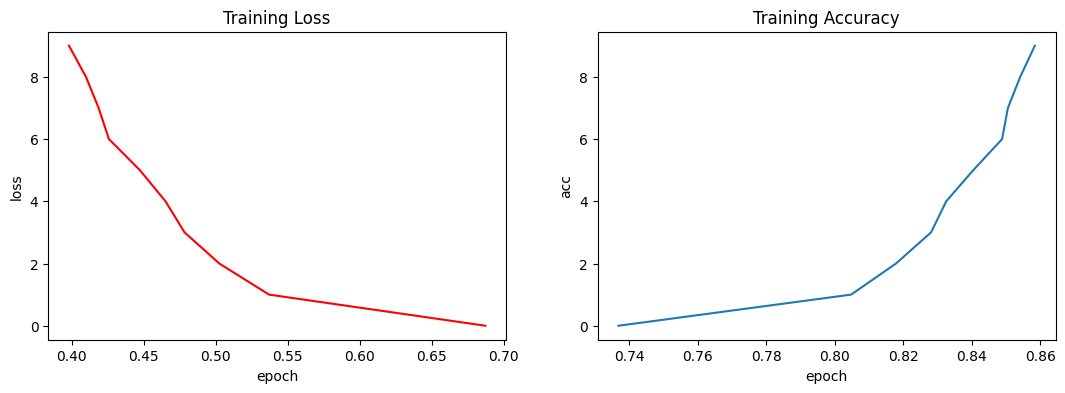

In [16]:
fig, axe = plt.subplots(1, 2, figsize=(13, 4))
axe[0].plot(loss_list, range(10), label="loss",color="red")
axe[0].set_xlabel("epoch")
axe[0].set_ylabel("loss")
axe[0].set_title("Training Loss")
axe[1].plot(acc_list, range(10), label="accuracy")
axe[1].set_xlabel("epoch")
axe[1].set_ylabel("acc")
axe[1].set_title("Training Accuracy")
plt.show()

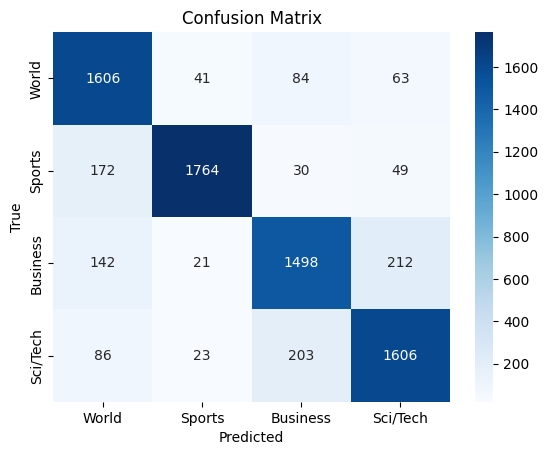

In [17]:
test(model, test_loader)